In [2]:
# Imports
import pandas as pd
import numpy as np
import csv
import nltk
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from collections import defaultdict
from sklearn import model_selection, svm, naive_bayes, metrics
from sklearn.ensemble import RandomForestClassifier
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, accuracy_score, f1_score, confusion_matrix, recall_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
from keras.preprocessing import text, sequence
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [4]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Read the labels and the data
labels = pd.read_csv('sarcasm.csv', dtype=float, usecols= ['label'])  
sarcasm_data = pd.read_csv('sarcasm.csv', dtype= str, usecols = ['comment']) 
##############
# Shuffle the Dataset.
shuffled_df = pd.read_csv('sarcasm.csv', dtype= str, usecols= ['label', 'comment'])
print(shuffled_df)
shuffled_df['label'] = shuffled_df['label'].astype(int)
shuffled_df = pd.DataFrame(shuffled_df)
# Put all the fraud class in a separate dataset.
fraud_df = shuffled_df.loc[shuffled_df['label'] == 1]

#Randomly select 42319 observations from the non-fraud (majority class)
non_fraud_df = shuffled_df.loc[shuffled_df['label'] == 0].sample(n=42319, random_state=42)

# Concatenate both dataframes again
normalized_df = pd.concat([fraud_df, non_fraud_df]).reset_index()
labels = normalized_df['label']
sarcasm_data = normalized_df['comment']
sarcasm_data = pd.DataFrame(sarcasm_data)

###############
sarcasm_data['comment'].dropna(inplace=True)
sarcasm_data['comment'] = sarcasm_data['comment'].astype(str)

# make all comments lowercase
sarcasm_data['comment'] = sarcasm_data['comment'].str.lower()

# remove punctuations
def remove_punctuations(text):
    for char in string.punctuation:
        text = text.replace(char, '')
    return text
sarcasm_data['comment'] = sarcasm_data['comment'].apply(remove_punctuations)
# tokenization
sarcasm_data['comment'] = sarcasm_data['comment'].apply(word_tokenize)

# tag adjectives, verbs and adverbs for lemmatization
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ 
tag_map['V'] = wn.VERB 
tag_map['R'] = wn.ADV 

for i in range(sarcasm_data.shape[0]):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(sarcasm_data['comment'].iloc[i]):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    sarcasm_data.loc[i,'final'] = str(Final_words)
    
print("Finished preprocessing")
print(sarcasm_data)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


      label                                            comment
0         0                                         NC and NH.
1         0  You do know west teams play against west teams...
2         0  They were underdogs earlier today, but since G...
3         0  This meme isn't funny none of the "new york ni...
4         0                    I could use one of those tools.
...     ...                                                ...
99995     0                                         so jealous
99996     1  Yeah, we all know it is the Baby Boomers who h...
99997     0                           Story, setting, artstyle
99998     0  Ebola Virus to Papyrus to the German Iris to M...
99999     1                        Ford is just *that* good...

[100000 rows x 2 columns]
Finished preprocessing
                                                 comment  \
0               [but, theyll, have, all, those, reviews]   
1      [wow, it, is, totally, unreasonable, to, assum...   
2      [ho, ho

In [5]:
# Split the data into validation, test, training
Train_X, Data_X, Train_Y, Data_Y = model_selection.train_test_split(sarcasm_data['final'], labels, test_size=0.3)
Test_X, Val_X, Test_Y, Val_Y = model_selection.train_test_split(Data_X,Data_Y,test_size=1/3)
# Encode the labels 
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)
Val_Y = Encoder.fit_transform(Val_Y)
# Vectorize the text data
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(sarcasm_data['final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Val_X_Tfidf = Tfidf_vect.transform(Val_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
print(Tfidf_vect.vocabulary_) 
'''import gensim
import gensim.downloader as api

# Word2Vec

glove_vectors = api.load('glove-twitter-200') # glove-twitter-25 
words = set(glove_vectors.wv.vocab.keys() )
X_train_vect = np.array([np.array([glove_vectors.wv[i] for i in ls if i in words])for ls in Train_X])
X_test_vect = np.array([np.array([glove_vectors.wv[i] for i in ls if i in words])for ls in Test_X])
X_train_vect_avg = []
for v in X_train_vect:
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        
X_test_vect_avg = []
for v in X_test_vect:
    if v.size:
        X_test_vect_avg.append(v.mean(axis=0))
    else:
        X_test_vect_avg.append(np.zeros(100, dtype=float))
scaler = MinMaxScaler()
Train_X_w2v_scaled = scaler.fit_transform(X_train_vect_avg)
Test_X_w2v_scaled = scaler.fit_transform(X_test_vect_avg)
'''

'''
# Doc2Vec

def prepare_train_data(LoLoW):
   for i, LoW in enumerate(LoLoW):
      yield gensim.models.doc2vec.TaggedDocument(LoW, [i])


doc2vec_dataset = api.load("text8")
doc2vec_data = [data for data in doc2vec_dataset]
doc2vec_train = list(prepare_train_data(doc2vec_data))

doc2vec_model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
doc2vec_model.build_vocab(doc2vec_train)
doc2vec_model.train(doc2vec_train, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

Train_X_d2v = list(map(doc2vec_model.infer_vector, Train_X))
scaler = MinMaxScaler()
Train_X_d2v_scaled = scaler.fit_transform(Train_X_d2v)
Test_X_d2v_scaled = scaler.fit_transform(Text_X_d2v)
'''

{'theyll': 34514, 'review': 28874, 'wow': 38594, 'totally': 35101, 'unreasonable': 36449, 'assume': 2000, 'agency': 562, 'cover': 7253, 'bush': 4638, 'war': 37618, 'crime': 7418, 'muh': 22453, 'republican': 28653, 'party': 25168, 'would': 38584, 'partisan': 25161, 'fuck': 12941, 'ho': 15601, 'melania': 21182, 'say': 30141, 'way': 37765, 'could': 7190, 'happen': 14831, 'didnt': 8912, 'know': 18610, 'woman': 38434, 'cant': 4995, 'wait': 37540, 'potus': 26568, 'start': 32780, 'twitter': 35777, 'morning': 22227, 'joe': 17824, 'get': 13596, 'ta': 33799, 'love': 20005, 'teacher': 34082, 'give': 13750, 'exam': 11221, 'day': 8101, 'halloween': 14735, 'hoiberg': 15634, 'great': 14252, 'player': 26097, 'dwight': 10071, 'oh': 24130, 'never': 23128, 'realize': 28036, 'easy': 10171, 'every': 11153, 'lonely': 19880, 'person': 25605, 'earth': 10143, 'think': 34545, 'exactly': 11208, 'reason': 28054, 'whatsoever': 38032, 'hank': 14819, 'time': 34769, 'legend': 19264, 'tomorrow': 34979, 'remember': 285

"import gensim\nimport gensim.downloader as api\nglove_vectors = api.load('glove-twitter-200') # glove-twitter-25 \nwords = set(glove_vectors.wv.vocab.keys() )\nX_train_vect = np.array([np.array([glove_vectors.wv[i] for i in ls if i in words])for ls in Train_X])\nX_test_vect = np.array([np.array([glove_vectors.wv[i] for i in ls if i in words])for ls in Test_X])\nX_train_vect_avg = []\nfor v in X_train_vect:\n    if v.size:\n        X_train_vect_avg.append(v.mean(axis=0))\n    else:\n        X_train_vect_avg.append(np.zeros(100, dtype=float))\n        \nX_test_vect_avg = []\nfor v in X_test_vect:\n    if v.size:\n        X_test_vect_avg.append(v.mean(axis=0))\n    else:\n        X_test_vect_avg.append(np.zeros(100, dtype=float))\nscaler = MinMaxScaler()\nTrain_X_d2v_scaled = scaler.fit_transform(X_train_vect_avg)\nTest_X_d2v_scaled = scaler.fit_transform(X_test_vect_avg)"

SVM Accuracy Score ->  65.12466028595061
Precision ->  0.6588658865886589
Recall ->  0.6118939574874612
F1 Score ->  0.6345117949352981
Confusion Matrix for SVM:


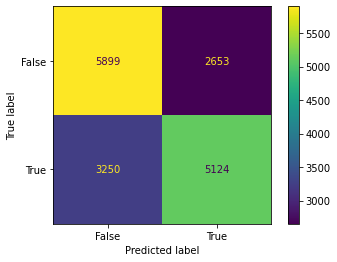

In [ ]:
# SVM
# fit the training dataset on the classifier when regularization param = 1
SVM = svm.SVC(C=1.0, kernel='linear', degree=3)
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Find the accuracy score
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, Test_Y)*100)
print("Precision -> ", precision_score(Test_Y, predictions_SVM, average="binary"))
print("Recall -> ", recall_score(Test_Y, predictions_SVM, average="binary"))
print("F1 Score -> ", f1_score(Test_Y, predictions_SVM, average="binary"))
print("Confusion Matrix for SVM:")
conf_matrix=confusion_matrix(Test_Y, predictions_SVM, labels=[0,1])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

SVM Accuracy Score ->  64.33297884910787
Precision ->  0.7151537470079176
Recall ->  0.46381657511344637
F1 Score ->  0.5626946758420862
Confusion Matrix for SVM:


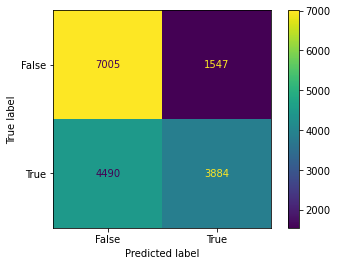

In [ ]:
# SVM
# fit the training dataset on the classifier when regularization param = 0.1
SVM = svm.SVC(C=0.1, kernel='linear', degree=3)
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Find the accuracy score
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, Test_Y)*100)
print("Precision -> ", precision_score(Test_Y, predictions_SVM, average="binary"))
print("Recall -> ", recall_score(Test_Y, predictions_SVM, average="binary"))
print("F1 Score -> ", f1_score(Test_Y, predictions_SVM, average="binary"))
print("Confusion Matrix for SVM:")
conf_matrix=confusion_matrix(Test_Y, predictions_SVM, labels=[0,1])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

SVM Accuracy Score ->  63.47040056717476
Precision ->  0.6358675430981025
Recall ->  0.6122522092190112
F1 Score ->  0.623836466508487
Confusion Matrix for SVM:


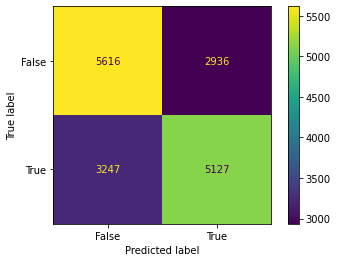

In [ ]:
# SVM
# fit the training dataset on the classifier when regularization param = 10
SVM = svm.SVC(C=10, kernel='linear', degree=3)
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Find the accuracy score
print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, Test_Y)*100)
print("Precision -> ", precision_score(Test_Y, predictions_SVM, average="binary"))
print("Recall -> ", recall_score(Test_Y, predictions_SVM, average="binary"))
print("F1 Score -> ", f1_score(Test_Y, predictions_SVM, average="binary"))
print("Confusion Matrix for SVM:")
conf_matrix=confusion_matrix(Test_Y, predictions_SVM, labels=[0,1])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

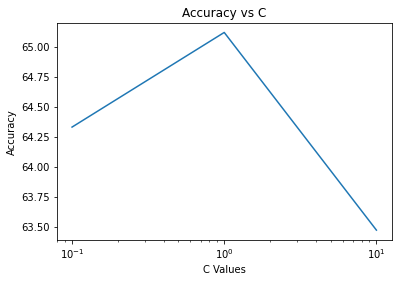

Optimum C:  1
Optimal SVM Accuracy Score for optimum C:  65.12


In [ ]:
#plot accuracies vs reg param
Cs = [0.1, 1, 10]
accuracy_scores = [64.33, 65.12, 63.47]

plt.semilogx(Cs, accuracy_scores)
plt.title("Accuracy vs C")
plt.xlabel("C Values")
plt.ylabel("Accuracy")
plt.show()

#optimum parameter
opt_i = np.argmax(accuracy_scores)
print("Optimum C: ", Cs[opt_i])
print("Optimal SVM Accuracy Score for optimum C: ", accuracy_scores[opt_i])

In [11]:
# Kernel types
Ks = ["linear", "poly", "rbf"]
accuracy_scores = []
for k in Ks:
    SVM = svm.SVC(C=1, kernel=k)
    SVM.fit(Train_X_Tfidf,Train_Y)
    # predict the labels on validation dataset
    predictions_SVM = SVM.predict(Test_X_Tfidf)
    acc = accuracy_score(predictions_SVM, Test_Y)*100
    accuracy_scores.append(acc)
    print("Accuracy is ", acc, " for Kernel Type = ", k)

Accuracy is  65.00649887746663  for Kernel Type =  linear
Accuracy is  64.26208200401749  for Kernel Type =  poly
Accuracy is  66.71983930048447  for Kernel Type =  rbf


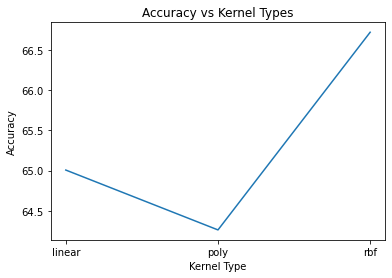

Optimum C:  rbf
Optimal SVM Accuracy Score for optimum Kernel:  66.71983930048447


In [16]:
#plot accuracies vs alphas
plt.plot(Ks, accuracy_scores)
plt.title("Accuracy vs Kernel Types")
plt.xlabel("Kernel Type")
plt.ylabel("Accuracy")
plt.show()

#optimum parameter
opt_i = np.argmax(accuracy_scores)
print("Optimum C: ", Ks[opt_i])
print("Optimal SVM Accuracy Score for optimum Kernel: ", accuracy_scores[opt_i])

SVM Accuracy Score for kernel linear  ->  65.00649887746663
Precision ->  0.6934835076427996
Recall ->  0.6071135109754666
F1 Score ->  0.6474306816048069
Confusion Matrix for SVM:


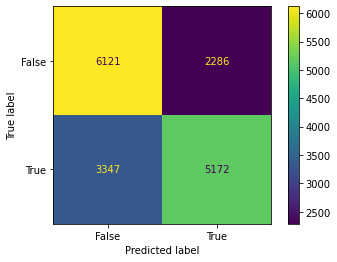

SVM Accuracy Score for kernel poly  ->  64.26208200401749
Precision ->  0.6934835076427996
Recall ->  0.6071135109754666
F1 Score ->  0.6474306816048069
Confusion Matrix for SVM:


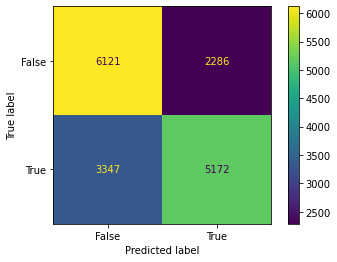

SVM Accuracy Score for kernel rbf  ->  66.71983930048447
Precision ->  0.6934835076427996
Recall ->  0.6071135109754666
F1 Score ->  0.6474306816048069
Confusion Matrix for SVM:


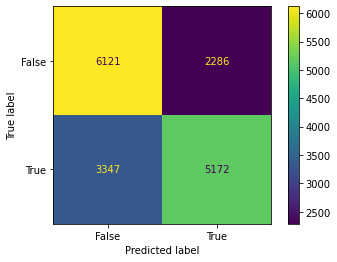

In [15]:
#printing conf matrix for kernel types
i=0;
for ac in accuracy_scores:
  print("SVM Accuracy Score for kernel", Ks[i], " -> ", ac)
  print("Precision -> ", precision_score(Test_Y, predictions_SVM, average="binary"))
  print("Recall -> ", recall_score(Test_Y, predictions_SVM, average="binary"))
  print("F1 Score -> ", f1_score(Test_Y, predictions_SVM, average="binary"))
  print("Confusion Matrix for SVM:")
  conf_matrix=confusion_matrix(Test_Y, predictions_SVM, labels=[0,1])
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
  cm_display.plot()
  plt.show()
  i=i+1

In [17]:
gammas = [2**-1, 2**0, 2**1]
accuracy_scores = []
for g in gammas:
    SVM = svm.SVC(C=1, kernel='rbf', gamma=g)
    SVM.fit(Train_X_Tfidf,Train_Y)
    # predict the labels on validation dataset
    predictions_SVM = SVM.predict(Test_X_Tfidf)
    acc = accuracy_score(predictions_SVM, Test_Y)*100
    accuracy_scores.append(acc)
    print("Accuracy is ", acc, " for Gamma = ", g)



Accuracy is  66.3299066524873  for Gamma =  0.5
Accuracy is  66.71393123006027  for Gamma =  1
Accuracy is  66.92662176533145  for Gamma =  2


In [18]:
gammas = [5, 10]
for g in gammas:
    SVM = svm.SVC(C=1, kernel='rbf', gamma=g)
    SVM.fit(Train_X_Tfidf,Train_Y)
    # predict the labels on validation dataset
    predictions_SVM = SVM.predict(Test_X_Tfidf)
    acc = accuracy_score(predictions_SVM, Test_Y)*100
    accuracy_scores.append(acc)
    print("Accuracy is ", acc, " for Gamma = ", g)

Accuracy is  65.32553468037338  for Gamma =  5
Accuracy is  53.87569419827485  for Gamma =  10


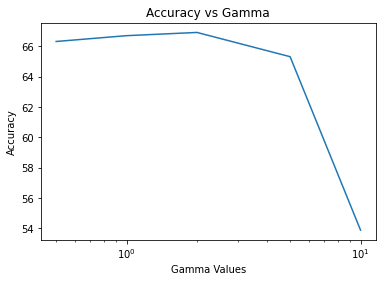

Optimum Gamma:  2
Optimal SVM Accuracy Score for optimum Gamma:  66.92662176533145


In [19]:
#plot accuracies vs gamma
gammas = [0.5,1,2,5,10]
plt.semilogx(gammas, accuracy_scores)
plt.title("Accuracy vs Gamma")
plt.xlabel("Gamma Values")
plt.ylabel("Accuracy")
plt.show()

#optimum parameter
opt_i = np.argmax(accuracy_scores)
print("Optimum Gamma: ", gammas[opt_i])
print("Optimal SVM Accuracy Score for optimum Gamma: ", accuracy_scores[opt_i])

SVM Accuracy Score for gamma 0.5  ->  66.3299066524873
Precision ->  0.5229529335912315
Recall ->  0.9521070548186407
F1 Score ->  0.6751009197220026
Confusion Matrix for SVM:


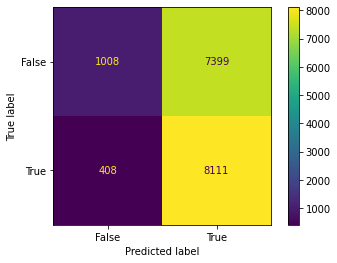

SVM Accuracy Score for gamma 1  ->  66.71393123006027
Precision ->  0.5229529335912315
Recall ->  0.9521070548186407
F1 Score ->  0.6751009197220026
Confusion Matrix for SVM:


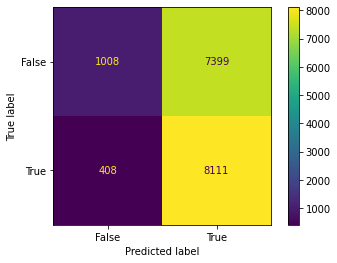

SVM Accuracy Score for gamma 2  ->  66.92662176533145
Precision ->  0.5229529335912315
Recall ->  0.9521070548186407
F1 Score ->  0.6751009197220026
Confusion Matrix for SVM:


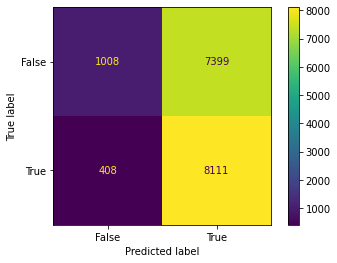

SVM Accuracy Score for gamma 5  ->  65.32553468037338
Precision ->  0.5229529335912315
Recall ->  0.9521070548186407
F1 Score ->  0.6751009197220026
Confusion Matrix for SVM:


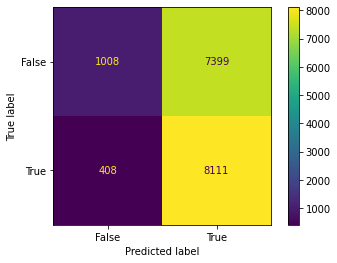

SVM Accuracy Score for gamma 10  ->  53.87569419827485
Precision ->  0.5229529335912315
Recall ->  0.9521070548186407
F1 Score ->  0.6751009197220026
Confusion Matrix for SVM:


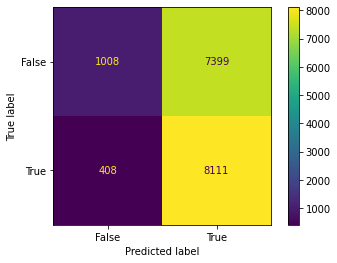

In [20]:
#printing conf matrix for different gammas
i=0;
for ga in accuracy_scores:
  print("SVM Accuracy Score for gamma", gammas[i], " -> ", ga)
  print("Precision -> ", precision_score(Test_Y, predictions_SVM, average="binary"))
  print("Recall -> ", recall_score(Test_Y, predictions_SVM, average="binary"))
  print("F1 Score -> ", f1_score(Test_Y, predictions_SVM, average="binary"))
  print("Confusion Matrix for SVM:")
  conf_matrix=confusion_matrix(Test_Y, predictions_SVM, labels=[0,1])
  cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
  cm_display.plot()
  plt.show()
  i=i+1

SVM conf matrix for optimal parameters
SVM Accuracy Score:  66.92662176533145
Precision:  0.5229529335912315
Recall:  0.9521070548186407
F1 Score:  0.6751009197220026


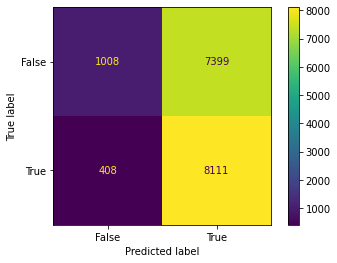

True Positive 8111
True Negative 1008
False Positive 7399
False Negative 408
NPV:  0.711864406779661
FPR:  0.8800999167360533
FDR:  0.47704706640876854


In [21]:
#optimum parameters for SVM
print("SVM conf matrix for optimal parameters")
print("SVM Accuracy Score: ", accuracy_scores[opt_i])
print("Precision: ", precision_score(Test_Y, predictions_SVM, average="binary"))
print("Recall: ", recall_score(Test_Y, predictions_SVM, average="binary"))
print("F1 Score: ", f1_score(Test_Y, predictions_SVM, average="binary"))
conf_matrix=confusion_matrix(Test_Y, predictions_SVM, labels=[0,1])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
tn, fp, fn, tp = confusion_matrix(list(Test_Y), list(predictions_SVM), labels=[0, 1]).ravel()
print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

npv = tn / (tn+fn)
print("NPV: ", npv)
fpr = fp / (fp+tn)
print("FPR: ", fpr)
fdr = fp / (tp+fp)
print("FDR: ", fdr)

RFC Accuracy Score -> 50.26586316908897
Precision ->  0.5064478311840562
Recall ->  0.3559741024131842
F1 Score ->  0.4180837826627955
Confusion Matrix for RFC:


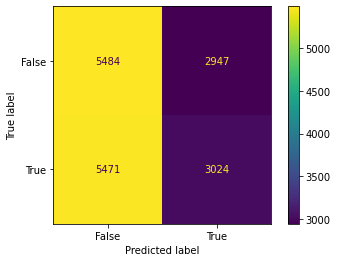

In [ ]:
# Random Forest
RFC = RandomForestClassifier()
# fit the training dataset on the classifier
RFC.fit(Train_X_Tfidf, Train_Y)
# predict the labels on validation set
predictions_RFC = RFC.predict(Test_X_Tfidf)
# Calc. accuracy
print("RFC Accuracy Score ->", accuracy_score(predictions_RFC, Test_Y)*100)
print("Precision -> ", precision_score(Test_Y, predictions_RFC, average="binary"))
print("Recall -> ", recall_score(Test_Y, predictions_RFC, average="binary"))
print("F1 Score -> ", f1_score(Test_Y, predictions_RFC, average="binary"))
print("Confusion Matrix for RFC:")
conf_matrix= confusion_matrix(Test_Y, predictions_RFC, labels=[0,1])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

RFC Accuracy Score:  65.11284414510222
Precision:  0.6669309023649095
Recall:  0.5986717267552182
F1 Score:  0.6309605649646897


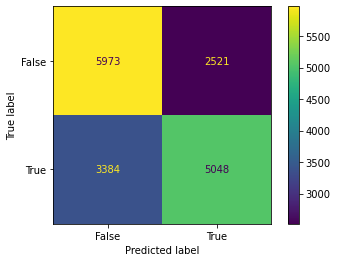

True Positive 5048
True Negative 5973
False Positive 2521
False Negative 3384
NPV:  0.6383456235973068
FPR:  0.2967977395808806
FDR:  0.3330690976350905


In [ ]:
# Tests for RFC
# Random Forest
RFC = RandomForestClassifier(n_estimators=200, min_samples_split = 2)
# fit the training dataset on the classifier
RFC.fit(Train_X_Tfidf, Train_Y)
# predict the labels on validation set
predictions_RFC = RFC.predict(Test_X_Tfidf)
acc = accuracy_score(predictions_RFC, Test_Y)*100

#optimum parameter
print("RFC Accuracy Score: ", acc)
print("Precision: ", precision_score(Test_Y, predictions_RFC, average="binary"))
print("Recall: ", recall_score(Test_Y, predictions_RFC, average="binary"))
print("F1 Score: ", f1_score(Test_Y, predictions_RFC, average="binary"))
conf_matrix=confusion_matrix(Test_Y, predictions_RFC, labels=[0,1])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
tn, fp, fn, tp = confusion_matrix(list(Test_Y), list(predictions_RFC), labels=[0, 1]).ravel()
print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

npv = tn / (tn+fn)
print("NPV: ", npv)
fpr = fp / (fp+tn)
print("FPR: ", fpr)
fdr = fp / (tp+fp)
print("FDR: ", fdr)


NAIVE BAYES Accuracy Score -> 52.31596360628619
Precision ->  0.5138670852956567
Recall ->  0.9247792819305474
F1 Score ->  0.6606399529075391
Confusion Matrix for RFC:


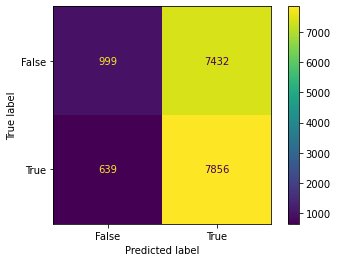

In [ ]:
#Naive Bayes 
NAIVE_BAYES = naive_bayes.MultinomialNB()
# fit the training dataset on the classifier
NAIVE_BAYES.fit(Train_X_Tfidf, Train_Y)
# predict the labels on validation set
predictions_NAIVE_BAYES = NAIVE_BAYES.predict(Test_X_Tfidf)
# Calc. accuracy
print("NAIVE BAYES Accuracy Score ->", accuracy_score(predictions_NAIVE_BAYES, Test_Y)*100)
print("Precision -> ", precision_score(Test_Y, predictions_NAIVE_BAYES, average="binary"))
print("Recall -> ", recall_score(Test_Y, predictions_NAIVE_BAYES, average="binary"))
print("F1 Score -> ", f1_score(Test_Y, predictions_NAIVE_BAYES, average="binary"))
print("Confusion Matrix for RFC:")
conf_matrix=confusion_matrix(Test_Y, predictions_NAIVE_BAYES, labels=[0,1])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

Accuracy is  61.83977313009571  for alpha =  0.001
Accuracy is  61.9106699751861  for alpha =  0.01
Accuracy is  62.37149946827366  for alpha =  0.1
Accuracy is  63.824884792626726  for alpha =  1
Accuracy is  64.75835991965025  for alpha =  10
Accuracy is  64.29162235613849  for alpha =  100


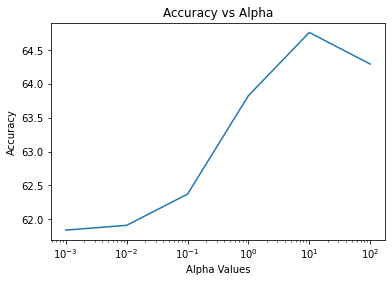

Optimum alpha:  10
Naive Bayes Accuracy Score:  64.75835991965025
Precision:  0.6396129766647695
Recall:  0.661292220783806
F1 Score:  0.650271959263974


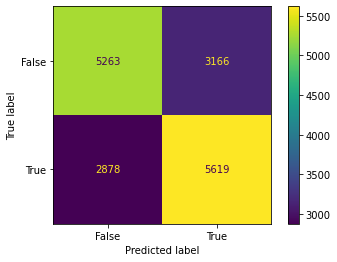

True Positive 5619
True Negative 5263
False Positive 3166
False Negative 2878
NPV:  0.6464807763174057
FPR:  0.3756080199311899
FDR:  0.3603870233352305


In [ ]:
# Tests for MNB
# fit the training dataset on the NB classifier
alphas = [0.001, 0.01, 0.1, 1, 10, 100]
accuracy_scores = []
for a in alphas:
    NAIVE_BAYES = naive_bayes.MultinomialNB(alpha=a)
    NAIVE_BAYES.fit(Train_X_Tfidf,Train_Y)
    predictions_NAIVE_BAYES = NAIVE_BAYES.predict(Test_X_Tfidf)
    acc = accuracy_score(predictions_NAIVE_BAYES, Test_Y)*100
    accuracy_scores.append(acc)
    print("Accuracy is ", acc, " for alpha = ", a)

#plot accuracies vs alphas
plt.semilogx(alphas, accuracy_scores)
plt.title("Accuracy vs Alpha")
plt.xlabel("Alpha Values")
plt.ylabel("Accuracy")
plt.show()

#optimum parameter
opt_i = np.argmax(accuracy_scores)
print("Optimum alpha: ", alphas[opt_i])
print("Naive Bayes Accuracy Score: ", accuracy_scores[opt_i])
print("Precision: ", precision_score(Test_Y, predictions_NAIVE_BAYES, average="binary"))
print("Recall: ", recall_score(Test_Y, predictions_NAIVE_BAYES, average="binary"))
print("F1 Score: ", f1_score(Test_Y, predictions_NAIVE_BAYES, average="binary"))
conf_matrix=confusion_matrix(Test_Y, predictions_NAIVE_BAYES, labels=[0,1])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
tn, fp, fn, tp = confusion_matrix(list(Test_Y), list(predictions_NAIVE_BAYES), labels=[0, 1]).ravel()
print('True Positive', tp)
print('True Negative', tn)
print('False Positive', fp)
print('False Negative', fn)

npv = tn / (tn+fn)
print("NPV: ", npv)
fpr = fp / (fp+tn)
print("FPR: ", fpr)
fdr = fp / (tp+fp)
print("FDR: ", fdr)